In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import time 

URL = "https://www.oref.org.il//Shared/Ajax/GetAlarmsHistory.aspx"
FROM_DATE = '7.10.23'
TO_DATE = '11.11.23'
DAYS_INTERVAL = 2
CSV_FILE_PATH = "C:/Projects/Python/Projects/BestTimeToShower/data/data.csv"
SLEEP_TIME = 5

In [139]:
def get_user_settlement():
    user_settlment = input("Please input the settlement where you would like to map the distribution of alarms\n"
                           "here ---> ")
    return user_settlment

def get_request(current_date, dest_date, alerts_list):
    try:    
        params = {'lang':'en',
                    'fromDate': current_date,
                    'toDate': dest_date,
                    'mode': '0'}
        response = requests.get(URL, params=params)
        if response.status_code == 200:
            time.sleep(SLEEP_TIME)
            current_alerts_list = json.loads(response.text)
            missiles_alerts_list = [item for item in current_alerts_list if item['category_desc']=='Missiles']
            alerts_list += missiles_alerts_list
        else:
            response.raise_for_status()
        
    except requests.HTTPError as e:
        print(f"HTTP error occurred: {e}")    

def get_oref_alarms(from_date, to_date):
    all_time_alarams_list = []
    current_date = datetime.strptime(from_date, '%d.%m.%y')
    target_date = datetime.strptime(to_date, '%d.%m.%y')
    print(current_date)
    while current_date <= target_date:
        dest_date = current_date + timedelta(days=DAYS_INTERVAL)  
        get_request(current_date, dest_date, all_time_alarams_list)
        print(f"Get the alarms from date: {current_date} to date: {dest_date}")
        current_date += timedelta(days=DAYS_INTERVAL)
    
    difference = current_date - target_date
    days_diff = difference.days
    day_to_add = DAYS_INTERVAL-days_diff
    current_date -= timedelta(days=DAYS_INTERVAL) # return current_date to the correct date cause we add DAYS_INTERVAL at the end of while loop
    get_request(current_date, current_date + timedelta(days=day_to_add), all_time_alarams_list)
    
    df = pd.DataFrame(all_time_alarams_list)
    # Convert the data column to lowercase to make it easy to work with the dataframe in future
    df['data'] = df['data'].str.lower()
    df.to_csv(CSV_FILE_PATH)
    
     
#get_oref_alarms(FROM_DATE, TO_DATE)

2023-10-07 00:00:00
Get the alarms from date: 2023-10-07 00:00:00 to date: 2023-10-09 00:00:00
Get the alarms from date: 2023-10-09 00:00:00 to date: 2023-10-11 00:00:00
Get the alarms from date: 2023-10-11 00:00:00 to date: 2023-10-13 00:00:00
Get the alarms from date: 2023-10-13 00:00:00 to date: 2023-10-15 00:00:00
Get the alarms from date: 2023-10-15 00:00:00 to date: 2023-10-17 00:00:00
Get the alarms from date: 2023-10-17 00:00:00 to date: 2023-10-19 00:00:00
Get the alarms from date: 2023-10-19 00:00:00 to date: 2023-10-21 00:00:00
Get the alarms from date: 2023-10-21 00:00:00 to date: 2023-10-23 00:00:00
Get the alarms from date: 2023-10-23 00:00:00 to date: 2023-10-25 00:00:00
Get the alarms from date: 2023-10-25 00:00:00 to date: 2023-10-27 00:00:00
Get the alarms from date: 2023-10-27 00:00:00 to date: 2023-10-29 00:00:00
Get the alarms from date: 2023-10-29 00:00:00 to date: 2023-10-31 00:00:00
Get the alarms from date: 2023-10-31 00:00:00 to date: 2023-11-02 00:00:00
Get t

In [22]:
class AlertsAggregator:
    def __init__(self, df):
        self.df = df

    # This func get dataframe and return a set of all the settlement in df
    def return_data_list(self):
        items_lst = self.df['data'].tolist()
        items_lst_no_duplications = set(items_lst)
        return items_lst_no_duplications


    # This function get dataframe and settlement_name and return a list of all the settlement in the df that settlement_name is insid them
    def create_user_settl_lst(self, settlement):
        given_lst = self.return_data_list()
        settl_lst = []
        for item in given_lst:
            if settlement.lower() in item:
                if item not in settl_lst:
                    settl_lst.append(item)
        return settl_lst
    


    # This function display the distribution of alarms in a specific settlement
    def display_dist(self, settlement):
        settlement_lst= self.create_user_settl_lst(settlement)
        
        if settlement_lst != []:
            # Filtered the df by the given settlement lst
            filtered_df = self.df[self.df['data'].isin(settlement_lst)]
            
            # Access the 'time' column of the DataFrame
            filtered_df['time'] = pd.to_datetime(filtered_df['time'])

            # Plot histogram
            plt.hist(filtered_df['time'].dt.hour + filtered_df['time'].dt.minute / 60, bins=4 * 24, range=(0, 24), color='skyblue', edgecolor='black')

            plt.xlabel('Time')
            plt.ylabel('Alarms')
            plt.title(f"Distribution of alarms in {settlement}")
            # Set X-axis ticks and labels
            plt.xticks(range(24), labels=[str(i) for i in range(24)])
            plt.show()

        else:
            raise ValueError("You selected a Settlement that does not exist.")
        

    # This function receives df and settlement name then count the total amount of alerts in this settlement
    def alerts_count(self, settlement):
        user_settlement_lst= self.create_user_settl_lst(settlement)
        if user_settlement_lst != []:
            # Filtered the df by the given settlement lst
            filtered_df = self.df[self.df['data'].isin(user_settlement_lst)]
            return filtered_df.shape[0]
        else:
            raise ValueError("You selected a Settlement that does not exist.")
        

    # This function receives df and count the total amount of alerts in the requested date range
    def total_alerts_count(self):
        total_alerts = self.df.shape[0]
        return total_alerts
    
    
    # This function receives city, and range of time and returns the distribution of the alarms in quarters of an hour 
    def create_quarter_hour_column(self, settlement, start_time, end_time):
        settlement_lst= self.create_user_settl_lst(settlement)
        
        if settlement_lst != []:
            filtered_df = self.df[self.df['data'].isin(settlement_lst)]
            filtered_df['time'] = pd.to_datetime(filtered_df['time'])
            
            # Filter the deteframe by the start and end time of the user
            filtered_df = filtered_df[(filtered_df['time'].dt.hour >= start_time) & (filtered_df['time'].dt.hour < end_time)]
            
            # Create new column which represent the time of the alarm among 15 minuts 
            filtered_df['quarter_hour'] = filtered_df['time'].dt.minute // 15
            quarter_hour_counts = filtered_df['quarter_hour'].value_counts().reindex([0,1,2,3], fill_value=0)
            print(quarter_hour_counts)
            return quarter_hour_counts
        
        else:
            raise ValueError("You selected a Settlement that does not exist.")

    def best_time_to_shower(self, settlement, start_time, end_time):
        quarter_hour_counts = self.create_quarter_hour_column(settlement, start_time, end_time)
        # Detect the quarter of an hour that appeared the less
        best_time = quarter_hour_counts.idxmin()
        return (f"The best time to take a shower is at the quarter: {best_time}")
    

    def worst_time_to_shower(self, settlement, start_time, end_time):
        quarter_hour_counts = self.create_quarter_hour_column(settlement, start_time, end_time)
        # Detect the quarter of an hour that appeared the most
        worst_time = quarter_hour_counts.idxmax()
        return (f"The worst time to take a shower is at the quarter: {worst_time}")
    

    def poorest_city(self):
        city_alerts_count = self.df['data'].value_counts()
        poorest_city = city_alerts_count.idxmax()
        return poorest_city

In [23]:
def main():
    try:  
        dataframe = pd.read_csv(CSV_FILE_PATH)
        
        agg = AlertsAggregator(dataframe)  
        
        total_alert_count = agg.total_alerts_count()
        print(total_alert_count)
        city_alert_count = agg.alerts_count('tel aviv')
        print(city_alert_count)
        agg.display_dist('tel aviv')
        print(agg.best_time_to_shower('tel aviv', 8, 13))
        
        print(agg.worst_time_to_shower('tel aviv', 8, 13))
        print(agg.poorest_city())
    
    except ValueError as e:
        print(f"An error occured: {e}")

    except TypeError as e:
        print(f"An error occured: {e}")

    except Exception:
        raise Exception

    

7615
164


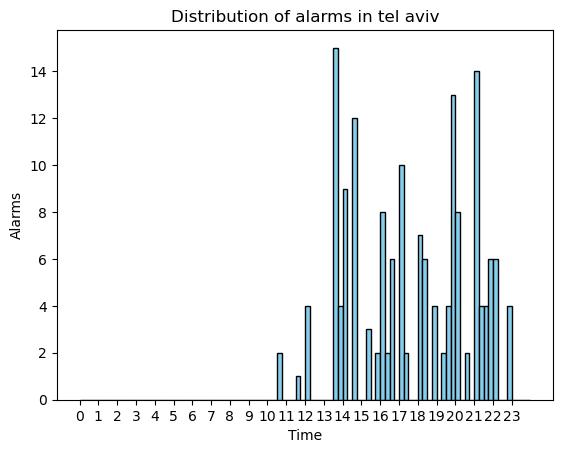

0    4
1    0
2    3
3    0
Name: quarter_hour, dtype: int64
The best time to take a shower is at the quarter: 1
0    4
1    0
2    3
3    0
Name: quarter_hour, dtype: int64
The worst time to take a shower is at the quarter: 0
ashkelon southern industrial zone


In [24]:
if __name__ == "__main__":
    main()